<a href="https://colab.research.google.com/github/florivz/DDM-Project-WS24-25/blob/main/analysis_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/florivz/DDM-Project-WS24-25.git

Cloning into 'DDM-Project-WS24-25'...
remote: Enumerating objects: 62, done.
remote: Counting objects: 100% (62/62), done.
remote: Compressing objects: 100% (59/59), done.
remote: Total 62 (delta 30), reused 15 (delta 2), pack-reused 0 (from 0)
Receiving objects: 100% (62/62), 35.75 MiB | 6.63 MiB/s, done.
Resolving deltas: 100% (30/30), done.
Updating files: 100% (12/12), done.


In [66]:
!pip install hdbscan

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 49.0 MB/s eta 0:00:00


In [2]:
import pandas as pd
import os
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from google.colab import userdata
from sklearn.cluster import KMeans
from matplotlib.patches import Patch
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import TruncatedSVD

# Loading the Data

In [3]:
pkl_path = 'DDM-Project-WS24-25/pkl/'

In [4]:
df_gdp = pd.read_pickle(pkl_path + "gdp.pickle")
df_pattern = pd.read_pickle(pkl_path + "naics_pattern.pickle")
df_occupation_1 = pd.read_pickle(pkl_path + "naics_occupation_part1.pickle")
df_occupation_2 = pd.read_pickle(pkl_path + "naics_occupation_part2.pickle")
df_occupation_3 = pd.read_pickle(pkl_path + "naics_occupation_part3.pickle")
df_county = pd.read_pickle(pkl_path + "county.pickle")
df_state = pd.read_pickle(pkl_path + 'state.pickle')

# Cleaning the data

In [5]:
df_pattern['FIPS'] = df_pattern['FIPS'].astype(str)

def add_zeros(code):
    if len(code) == 3:
        return '00' + code
    elif len(code) == 4:
        return '0' + code
    elif len(code) == 1:
        return '0000' + code
    return code

df_pattern['FIPS'] = df_pattern['FIPS'].apply(add_zeros)

In [6]:
df_occupation = pd.concat([df_occupation_1, df_occupation_2, df_occupation_3], ignore_index=True)
df_occupation.head()

,FIPS,State_GEOID,naics,NAICS_TITLE,emp_total_county_naics,OCC_CODE,OCC_TITLE,emp_occupation,state_name
0,12999,12,5613,Employment Services,1436559,49-9071,"Maintenance and Repair Workers, General",20639.514235,NaN
1,06999,6,5613,Employment Services,729335,49-9071,"Maintenance and Repair Workers, General",9414.167765,NaN
2,36999,36,5613,Employment Services,308333,49-9071,"Maintenance and Repair Workers, General",8332.850279,NaN
3,06037,6,8111,Automotive Repair and Maintenance,25081,49-3023,Automotive Service Technicians and Mechanics,5913.423292,California
4,48999,48,5613,Employment Services,340926,49-9071,"Maintenance and Repair Workers, General",5770.378034,NaN


# Feature Selection

## Filtering & Aggregating the industries with most establishments per FIPS

In [7]:
df_top_industries = df_pattern.groupby(['naics', 'DESCRIPTION']).agg({
    'emp': 'sum',
    'est': 'sum',
    'FIPS': 'nunique'
}).reset_index()

df_top_industries = df_top_industries.sort_values(by=['est', 'emp'], ascending=False)

df_top_industries.head(40)

,naics,DESCRIPTION,emp,est,FIPS
65,5617,Services to Buildings and Dwellings,2004960,220492,2530
13,2382,Building Equipment Contractors,2171001,193562,2756
67,8111,Automotive Repair and Maintenance,902870,164584,2725
14,2383,Building Finishing Contractors,811812,124074,2040
62,5413,"Architectural, Engineering, and Related Services",1579218,115269,1924
12,2381,"Foundation, Structure, and Building Exterior C...",901696,101383,2313
66,7139,Other Amusement and Recreation Industries,1092894,76488,2182
54,4413,"Automotive Parts, Accessories, and Tire Stores",532828,58112,2427
64,5613,Employment Services,7061425,57057,1306
51,4238,"Machinery, Equipment, and Supplies Merchant Wh...",739134,54251,1947


## Ranking the Industries

In [8]:
tool_consumption_ranking = {
    11: 2,   # Agriculture, Forestry, Fishing and Hunting
    21: 1,   # Mining
    22: 3,   # Utilities
    23: 1,   # Construction
    31: 1,   # Manufacturing
    32: 1,   # Manufacturing
    33: 1,   # Manufacturing
    42: 10,   # Wholesale Trade
    44: 10,   # Retail Trade
    45: 10,   # Retail Trade
    48: 3,   # Transportation and Warehousing
    49: 3,   # Transportation and Warehousing
    51: 10,   # Information
    52: 10,   # Finance and Insurance
    53: 8,   # Real Estate Rental and Leasing
    54: 4,  # Professional, Scientific, and Technical Services
    55: 10,   # Management of Companies and Enterprises
    56: 6,   # Administrative and Support and Waste Services
    61: 9,   # Educational Services
    62: 7,   # Health Care and Social Assistance
    71: 6,   # Arts, Entertainment, and Recreation
    72: 4,   # Accommodation and Food Services
    81: 8,   # Other Services (except Public Administration)
    92: 10    # Public Administration
}

def get_ranking(naics_code):
    naics_prefix = int(str(naics_code)[:2])  # Die ersten zwei Ziffern extrahieren
    return tool_consumption_ranking.get(naics_prefix, None)  # Ranking aus dem Dictionary holen

# Neue Spalte 'ranking' zu deinem DataFrame hinzufügen
df_top_industries['tool_consumption'] = df_top_industries['naics'].apply(get_ranking).reset_index(drop=True)

df_top_industries.head(10)

,naics,DESCRIPTION,emp,est,FIPS,tool_consumption
65,5617,Services to Buildings and Dwellings,2004960,220492,2530,1
13,2382,Building Equipment Contractors,2171001,193562,2756,1
67,8111,Automotive Repair and Maintenance,902870,164584,2725,1
14,2383,Building Finishing Contractors,811812,124074,2040,1
62,5413,"Architectural, Engineering, and Related Services",1579218,115269,1924,1
12,2381,"Foundation, Structure, and Building Exterior C...",901696,101383,2313,10
66,7139,Other Amusement and Recreation Industries,1092894,76488,2182,1
54,4413,"Automotive Parts, Accessories, and Tire Stores",532828,58112,2427,3
64,5613,Employment Services,7061425,57057,1306,1
51,4238,"Machinery, Equipment, and Supplies Merchant Wh...",739134,54251,1947,1


In [9]:
df_top_industries['tool_consumption'].isna().sum()

0

In [10]:
df_top_industries['rank_est'] = pd.qcut(
    df_top_industries['est'].rank(ascending=False),  # Rankiere absteigend
    10,                                              # In 10 gleich große Gruppen aufteilen
    labels=range(1, 11)                              # Label von 1 (höchste) bis 10
)

# Ranking für die Spalte 'emp' von 1 bis 10
df_top_industries['rank_emp'] = pd.qcut(
    df_top_industries['emp'].rank(ascending=False),  # Rankiere absteigend
    10,                                              # In 10 gleich große Gruppen aufteilen
    labels=range(1, 11)                              # Label von 1 (höchste) bis 10
)

In [11]:
df_top_industries.head()

,naics,DESCRIPTION,emp,est,FIPS,tool_consumption,rank_est,rank_emp
65,5617,Services to Buildings and Dwellings,2004960,220492,2530,1,1,1
13,2382,Building Equipment Contractors,2171001,193562,2756,1,1,1
67,8111,Automotive Repair and Maintenance,902870,164584,2725,1,1,1
14,2383,Building Finishing Contractors,811812,124074,2040,1,1,2
62,5413,"Architectural, Engineering, and Related Services",1579218,115269,1924,1,1,1


In [12]:
# Gewichtungen definieren
weight_tool_consumption = 0.5
weight_emp = 0.3
weight_est = 0.2

# Berechnung der gewichteten Rankings
df_top_industries['weighted_rank'] = (
    df_top_industries['tool_consumption'].astype(float) * weight_tool_consumption +
    df_top_industries['rank_emp'].astype(float) * weight_emp +
    df_top_industries['rank_est'].astype(float) * weight_est
)

df_top_industries.sort_values(by='weighted_rank').head(30)

,naics,DESCRIPTION,emp,est,FIPS,tool_consumption,rank_est,rank_emp,weighted_rank
65,5617,Services to Buildings and Dwellings,2004960,220492,2530,1,1,1,1.0
13,2382,Building Equipment Contractors,2171001,193562,2756,1,1,1,1.0
67,8111,Automotive Repair and Maintenance,902870,164584,2725,1,1,1,1.0
62,5413,"Architectural, Engineering, and Related Services",1579218,115269,1924,1,1,1,1.0
66,7139,Other Amusement and Recreation Industries,1092894,76488,2182,1,1,1,1.0
64,5613,Employment Services,7061425,57057,1306,1,2,1,1.2
14,2383,Building Finishing Contractors,811812,124074,2040,1,1,2,1.3
51,4238,"Machinery, Equipment, and Supplies Merchant Wh...",739134,54251,1947,1,2,2,1.5
21,3231,Printing and Related Support Activities,356146,21376,1116,1,2,3,1.8
50,4231,Motor Vehicle and Motor Vehicle Parts and Supp...,390199,21491,1030,1,2,3,1.8


In [13]:
top_5_naics = df_top_industries.sort_values(by='weighted_rank').head(5)['naics'].tolist()
top_5_naics

['5617', '2382', '8111', '5413', '7139']

# Filtering the FIPS with the highest amount of Top Industries


In [14]:
feature_df = pd.DataFrame(df_pattern['FIPS'].unique(), columns=['FIPS'])

for naics_code in top_5_naics:
    est_values = df_pattern[df_pattern['naics'] == naics_code].groupby('FIPS')['est'].sum().reset_index()
    est_values.rename(columns={'est': f'est_{naics_code}'}, inplace=True)
    feature_df = feature_df.merge(est_values, on='FIPS', how='left')

feature_df.fillna(0, inplace=True)

feature_df.rename(columns={f'est_{naics}': f'est_{naics}' for naics in top_5_naics}, inplace=True)

feature_df.head()

,FIPS,est_5617,est_2382,est_8111,est_5413,est_7139
0,01001,30.0,27.0,20.0,7.0,12.0
1,01003,229.0,187.0,93.0,94.0,69.0
2,01005,8.0,7.0,10.0,7.0,4.0
3,01007,5.0,8.0,7.0,0.0,0.0
4,01009,19.0,37.0,20.0,3.0,7.0


# Data Preprocessing

In [15]:
df_final = feature_df.copy()

In [16]:
df_final.head()

,FIPS,est_5617,est_2382,est_8111,est_5413,est_7139
0,01001,30.0,27.0,20.0,7.0,12.0
1,01003,229.0,187.0,93.0,94.0,69.0
2,01005,8.0,7.0,10.0,7.0,4.0
3,01007,5.0,8.0,7.0,0.0,0.0
4,01009,19.0,37.0,20.0,3.0,7.0


In [17]:
# Impute Missing GDP with 0
df_final = df_final.dropna()

## Unscaled Data

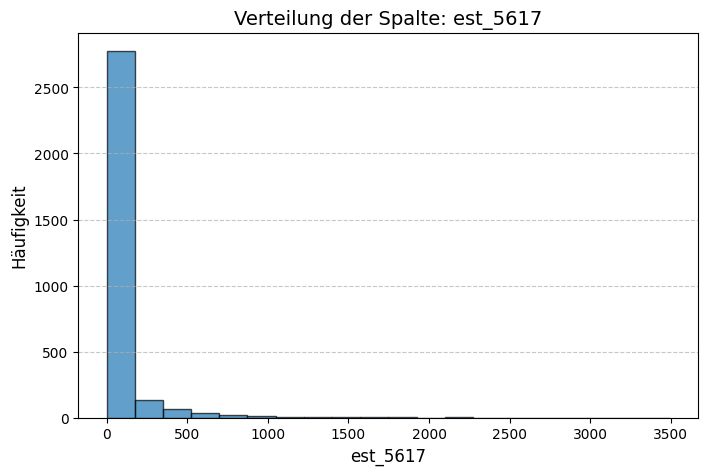

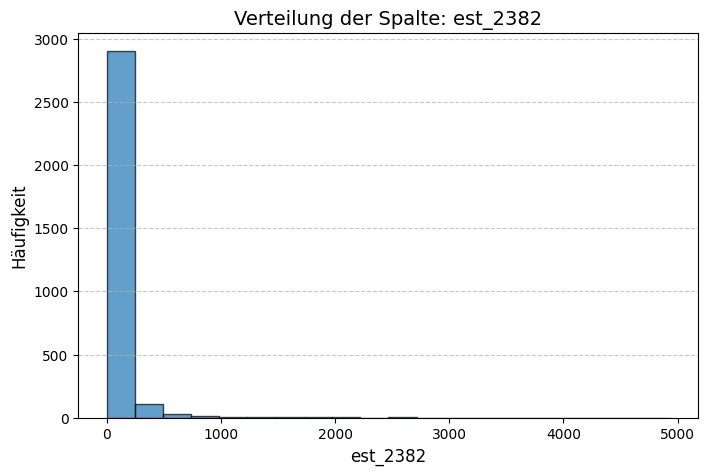

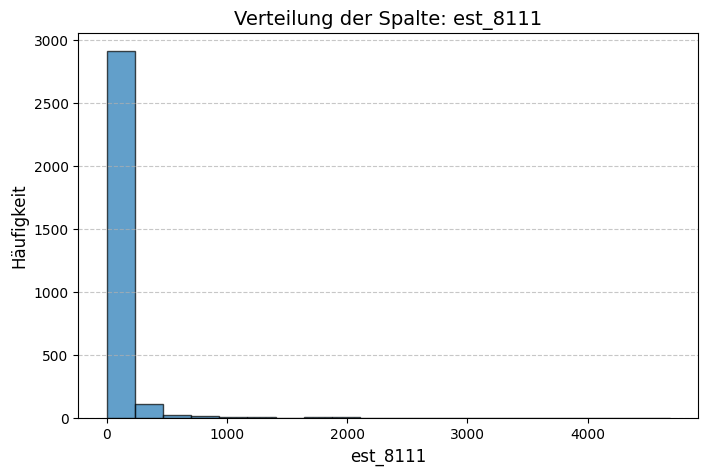

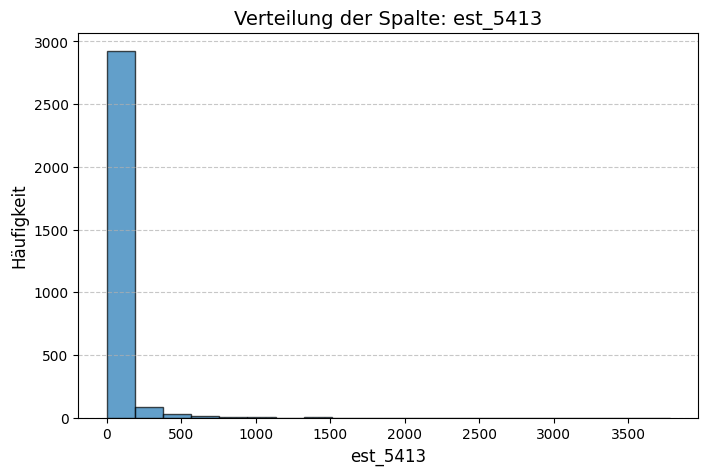

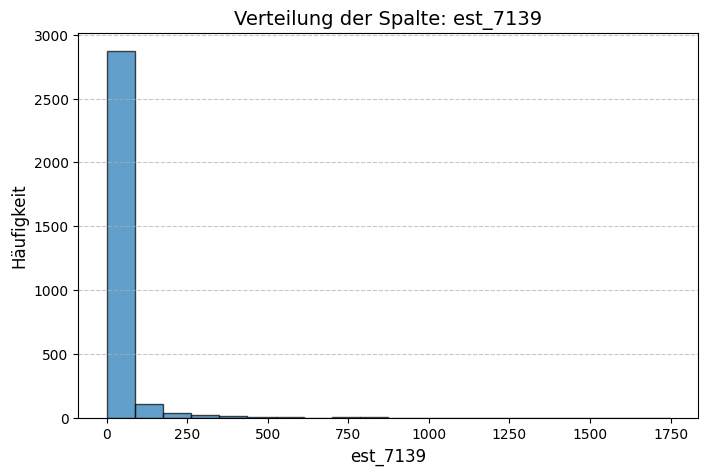

In [18]:
for column in df_final.columns[1:]:  # Verwende die Spalten aus df_final
    plt.figure(figsize=(8, 5))
    plt.hist(df_final[column], bins=20, edgecolor='black', alpha=0.7)
    plt.title(f'Verteilung der Spalte: {column}', fontsize=14)
    plt.xlabel(column, fontsize=12)
    plt.ylabel('Häufigkeit', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

## Standard Scaled

In [19]:
# Scaling the data to make them comparable
X = df_final.iloc[:, 1:5]

scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns = df_final.columns[1:5])
X_scaled.head()

,est_5617,est_2382,est_8111,est_5413
0,-0.204862,-0.192423,-0.208127,-0.210503
1,0.770483,0.662101,0.244148,0.389265
2,-0.312689,-0.299238,-0.270083,-0.210503
3,-0.327393,-0.293897,-0.288669,-0.258760
4,-0.258776,-0.139015,-0.208127,-0.238078


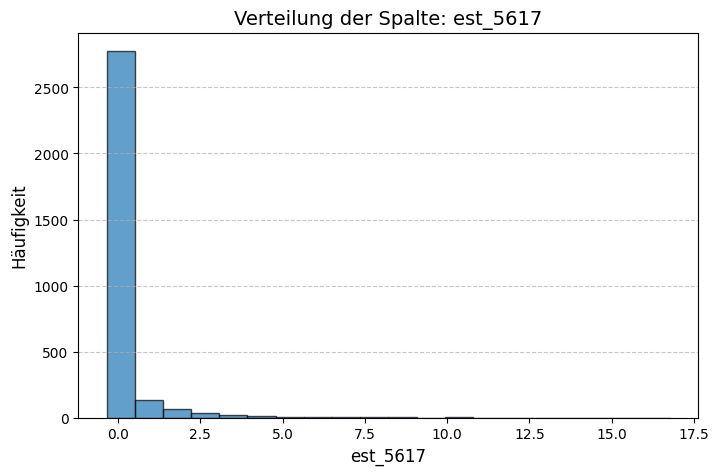

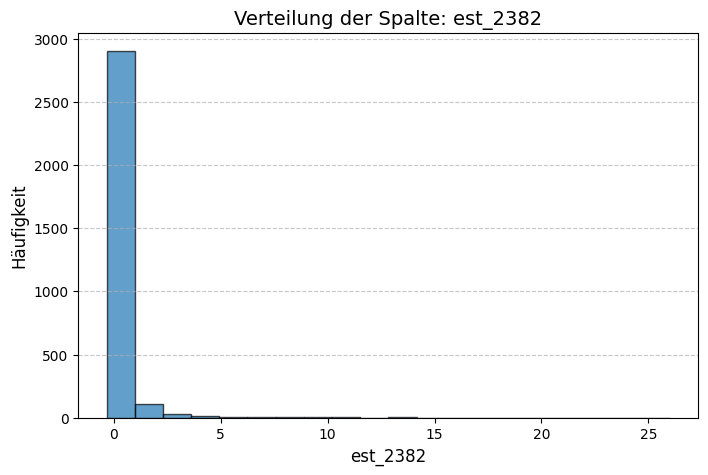

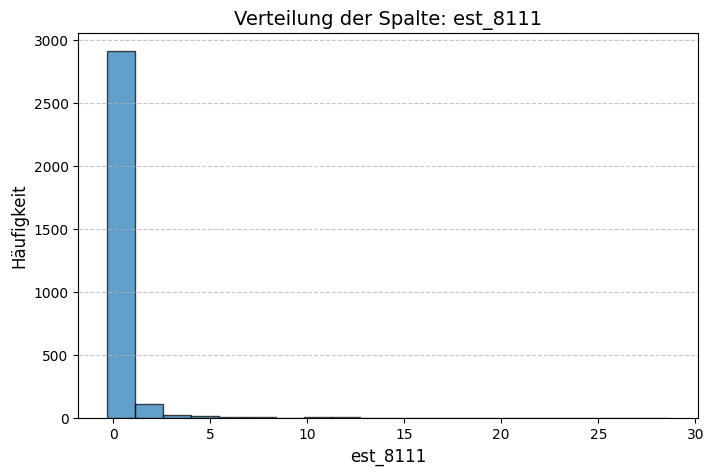

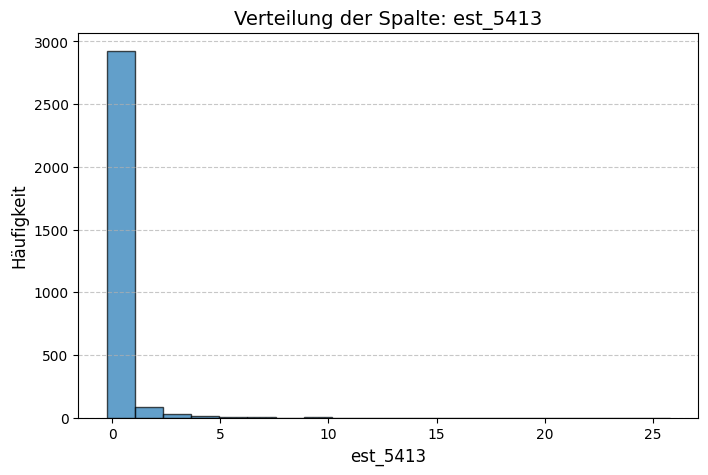

In [20]:
for column in X_scaled.columns:  # Verwende die Spalten aus X_scaled
    plt.figure(figsize=(8, 5))
    plt.hist(X_scaled[column], bins=20, edgecolor='black', alpha=0.7)
    plt.title(f'Verteilung der Spalte: {column}', fontsize=14)
    plt.xlabel(column, fontsize=12)
    plt.ylabel('Häufigkeit', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

## Log 10 Scaled

In [21]:
import numpy as np

X_log_scaled = np.log10(X + 1)
X_log_scaled = pd.DataFrame(X_log_scaled, columns=X_scaled.columns)

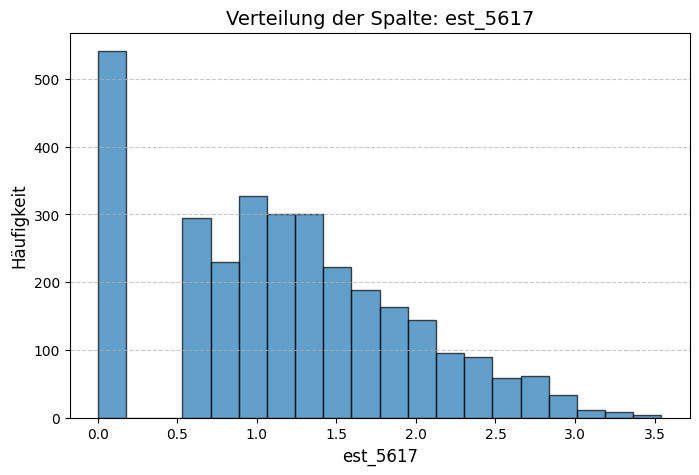

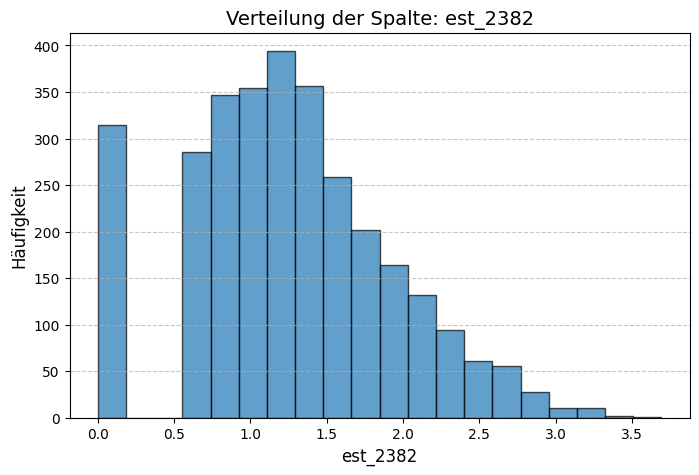

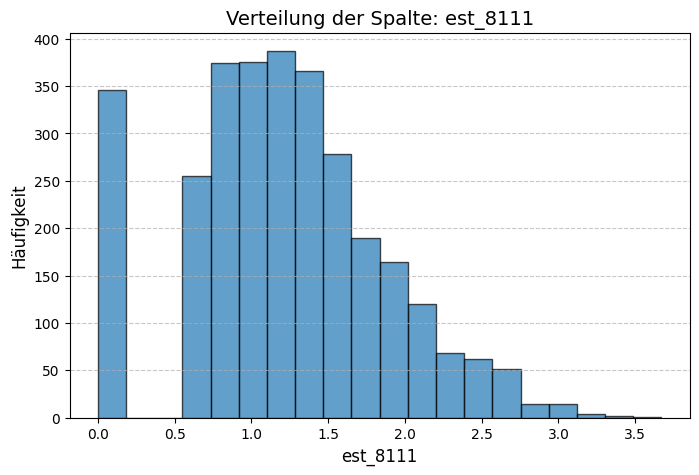

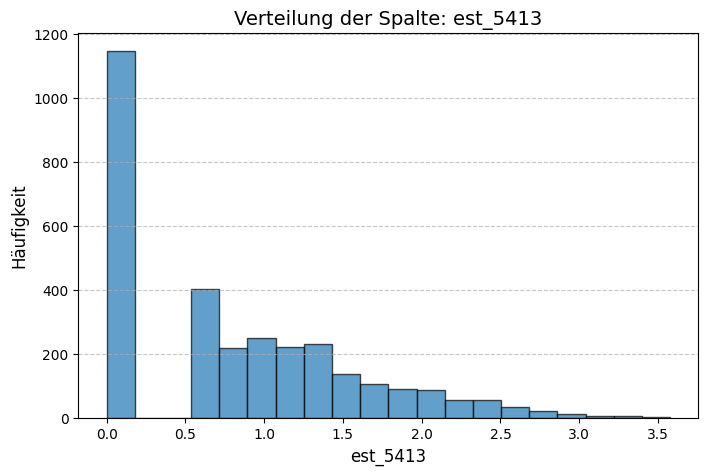

In [22]:
for column in X_log_scaled.columns:  # Verwende die Spalten aus X_scaled
    plt.figure(figsize=(8, 5))
    plt.hist(X_log_scaled[column], bins=20, edgecolor='black', alpha=0.7)
    plt.title(f'Verteilung der Spalte: {column}', fontsize=14)
    plt.xlabel(column, fontsize=12)
    plt.ylabel('Häufigkeit', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

# PCA

In [50]:
X_log_scaled.head()

,est_5617,est_2382,est_8111,est_5413
0,1.491362,1.447158,1.322219,0.903090
1,2.361728,2.274158,1.973128,1.977724
2,0.954243,0.903090,1.041393,0.903090
3,0.778151,0.954243,0.903090,0.000000
4,1.301030,1.579784,1.322219,0.602060


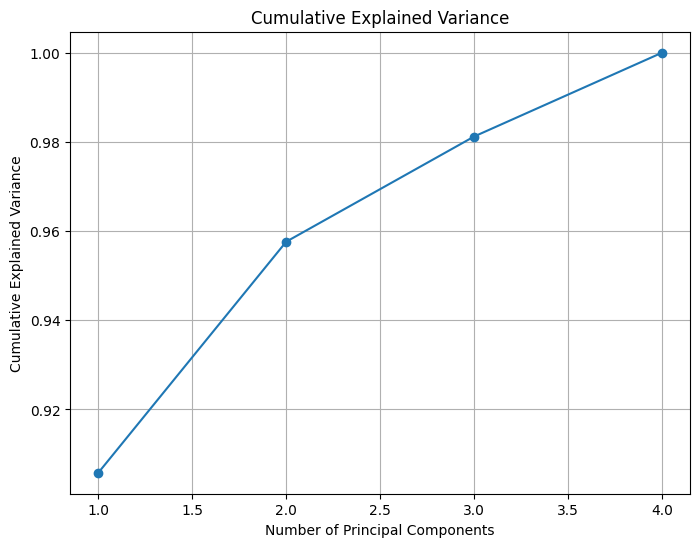

Number of components explaining 90% variance: 1


In [51]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

pca = PCA()
X_pca = pca.fit_transform(X_log_scaled)

plt.figure(figsize=(8, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.title('Cumulative Explained Variance')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid()
plt.show()

n_components = np.argmax(np.cumsum(pca.explained_variance_ratio_) >= 0.9) + 1
print(f'Number of components explaining 90% variance: {n_components}')


In [52]:
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_log_scaled)

# Clustering

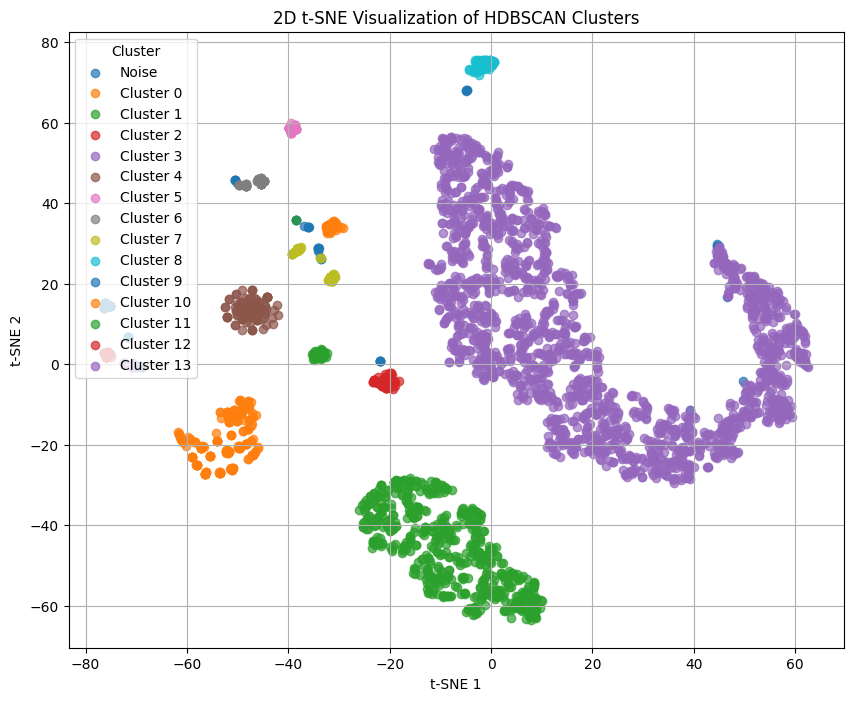

In [67]:
import hdbscan
from sklearn.manifold import TSNE

hdbscan_clusterer = hdbscan.HDBSCAN(min_samples=10, min_cluster_size=20)
clusters = hdbscan_clusterer.fit_predict(X_log_scaled)

df_final['cluster'] = clusters

tsne_2d = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne_2d = tsne_2d.fit_transform(X_log_scaled)

plt.figure(figsize=(10, 8))
unique_labels = sorted(set(clusters))

for cluster_label in unique_labels:
    indices = clusters == cluster_label
    label = 'Noise' if cluster_label == -1 else f'Cluster {cluster_label}'
    plt.scatter(
        X_tsne_2d[indices, 0],
        X_tsne_2d[indices, 1],
        label=label,
        alpha=0.7
    )

plt.title('2D t-SNE Visualization of HDBSCAN Clusters')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()


In [68]:
df_final['cluster'].unique()

array([ 3, 11,  4, 10,  1,  2,  9,  0,  7, 12,  8,  6, -1,  5, 13])

# Interpretation

In [70]:
df_final.head()

,FIPS,est_5617,est_2382,est_8111,est_5413,est_7139,cluster
0,01001,30.0,27.0,20.0,7.0,12.0,3
1,01003,229.0,187.0,93.0,94.0,69.0,3
2,01005,8.0,7.0,10.0,7.0,4.0,3
3,01007,5.0,8.0,7.0,0.0,0.0,11
4,01009,19.0,37.0,20.0,3.0,7.0,3


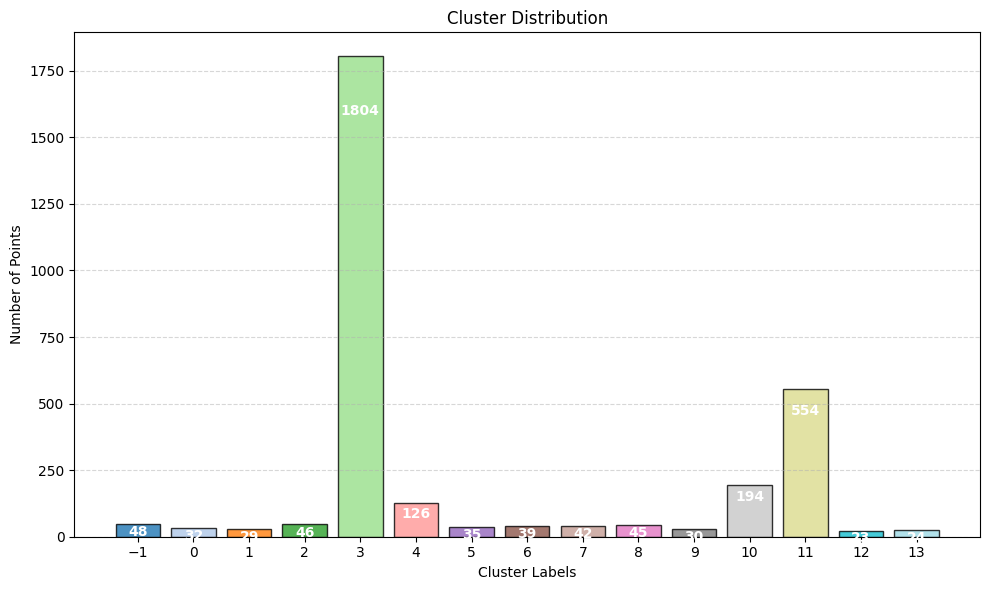

In [76]:
cluster_counts = df_final['cluster'].value_counts().sort_index()
unique_clusters = cluster_counts.index
colors = plt.cm.tab20(np.linspace(0, 1, len(unique_clusters)))

plt.figure(figsize=(10, 6))

bars = plt.bar(
    unique_clusters,
    cluster_counts,
    color=colors,
    edgecolor='black',
    alpha=0.8
)

for bar, count in zip(bars, cluster_counts):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() - (bar.get_height() * 0.1),
        f'{count}',
        ha='center',
        va='top',
        fontsize=10,
        color='white',
        fontweight='bold'
    )

plt.title('Cluster Distribution')
plt.xlabel('Cluster Labels')
plt.ylabel('Number of Points')
plt.xticks(unique_clusters)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [77]:
df_final.head()

,FIPS,est_5617,est_2382,est_8111,est_5413,est_7139,cluster
0,01001,30.0,27.0,20.0,7.0,12.0,3
1,01003,229.0,187.0,93.0,94.0,69.0,3
2,01005,8.0,7.0,10.0,7.0,4.0,3
3,01007,5.0,8.0,7.0,0.0,0.0,11
4,01009,19.0,37.0,20.0,3.0,7.0,3


In [80]:
cluster_summary = (
    df_final.groupby('cluster')
    .agg(
        count=('FIPS', 'size'),
        avg_est_5617=('est_5617', 'mean'),
        avg_est_2382=('est_2382', 'mean'),
        avg_est_8111=('est_8111', 'mean'),
        avg_est_5413=('est_5413', 'mean'),
        avg_est_7139=('est_7139', 'mean')
    )
    .reset_index()
)


cluster_summary.sort_values(by='count', ascending=False, inplace=True)

cluster_summary.head()

,cluster,count,avg_est_5617,avg_est_2382,avg_est_8111,avg_est_5413,avg_est_7139
4,3,1804,112.922395,96.094235,80.710643,56.762195,38.185144
12,11,554,7.864621,9.799639,9.796029,0.000000,3.135379
11,10,194,0.000000,5.500000,5.711340,0.000000,1.144330
5,4,126,0.000000,0.000000,0.000000,0.000000,0.666667
0,-1,48,244.687500,267.458333,244.145833,246.291667,109.875000


In [81]:
df_result = df_final[(df_final['cluster'] == 3)].reset_index(drop=True)
df_result.head()

,FIPS,est_5617,est_2382,est_8111,est_5413,est_7139,cluster
0,01001,30.0,27.0,20.0,7.0,12.0,3
1,01003,229.0,187.0,93.0,94.0,69.0,3
2,01005,8.0,7.0,10.0,7.0,4.0,3
3,01009,19.0,37.0,20.0,3.0,7.0,3
4,01015,54.0,48.0,55.0,15.0,17.0,3


In [82]:
len(df_result)

1804

# Visalization

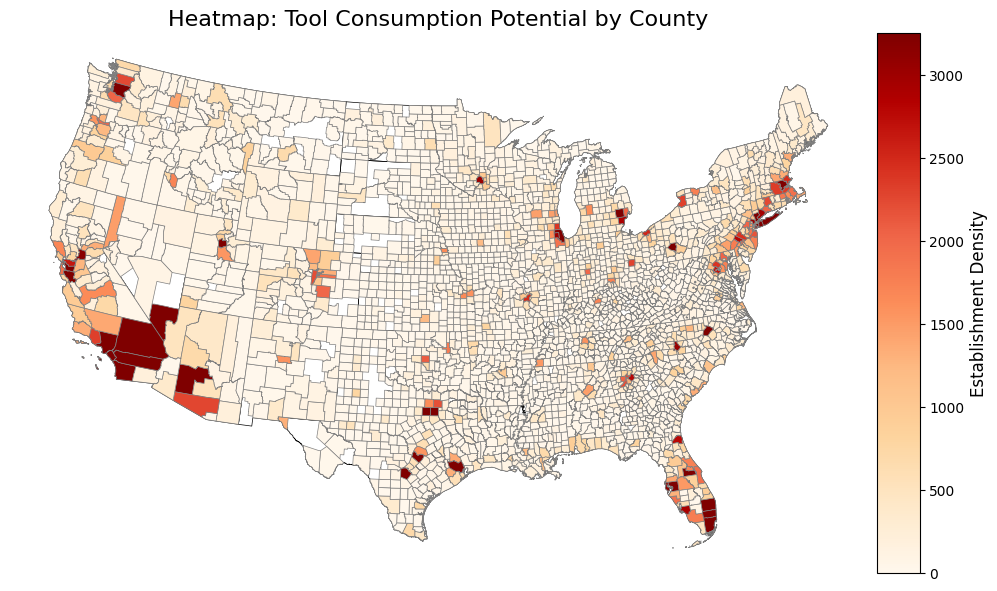

In [88]:
import geopandas as gpd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np

gdf_county = gpd.GeoDataFrame(df_county, geometry='geometry')
gdf_states = gpd.GeoDataFrame(df_state, geometry='geometry')

gdf_county.crs = 'epsg:4269'
gdf_states.crs = 'epsg:4269'

non_contiguous_states = [
    'Alaska', 'Hawaii', 'Puerto Rico',
    'Commonwealth of the Northern Mariana Islands',
    'American Samoa', 'United States Virgin Islands', 'Guam'
]

filtered_states = gdf_states[~gdf_states['NAME'].isin(non_contiguous_states)]
filtered_statefps = filtered_states['STATEFP'].unique()
filtered_county = gdf_county[gdf_county['STATEFP'].isin(filtered_statefps)]

gdf_cluster = filtered_county.merge(df_final, left_on='GEOID', right_on='FIPS', how='inner')

gdf_cluster['total_est'] = (
    gdf_cluster['est_5617'] +
    gdf_cluster['est_2382'] +
    gdf_cluster['est_8111'] +
    gdf_cluster['est_5413'] +
    gdf_cluster['est_7139']
)

gdf_cluster = gdf_cluster.to_crs('epsg:5070')
filtered_states = filtered_states.to_crs('epsg:5070')

fig, ax = plt.subplots(figsize=(15, 7))

vmin = gdf_cluster['total_est'].quantile(0.01)
vmax = gdf_cluster['total_est'].quantile(0.99)

filtered_states.plot(ax=ax, color='none', edgecolor='black', linewidth=0.5)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

heatmap = gdf_cluster.plot(
    column='total_est',
    cmap='OrRd',
    linewidth=0.5,
    ax=ax,
    edgecolor='0.5',
    legend=True,
    cax=cax,
    vmin=vmin,
    vmax=vmax
)

cax.set_ylabel('Establishment Density', fontsize=12)

ax.set_title('Heatmap: Tool Consumption Potential by County', fontsize=16)
ax.set_axis_off()

plt.show()


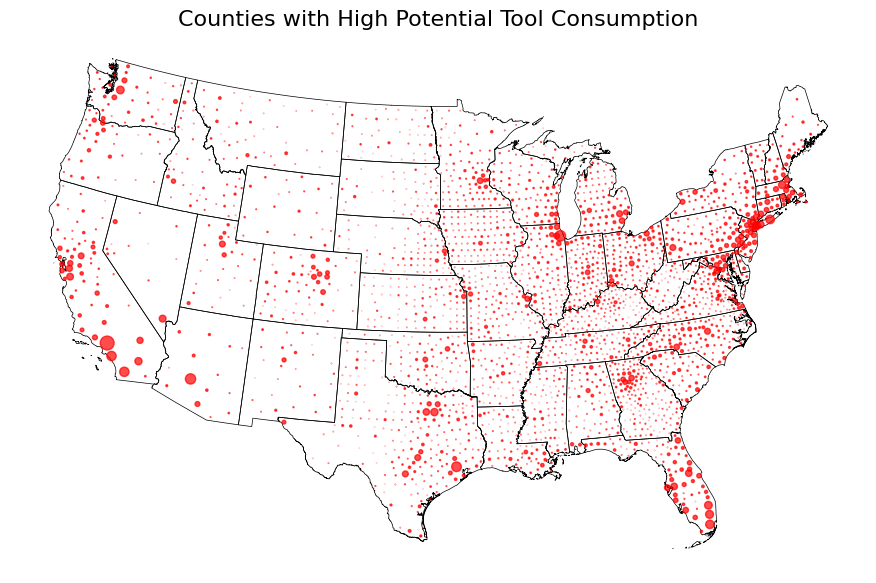

In [84]:
import geopandas as gpd
import matplotlib.pyplot as plt

gdf_county = gpd.GeoDataFrame(df_county, geometry='geometry')
gdf_states = gpd.GeoDataFrame(df_state, geometry='geometry')

gdf_county.crs = 'epsg:4269'
gdf_states.crs = 'epsg:4269'

non_contiguous_states = [
    'Alaska', 'Hawaii', 'Puerto Rico',
    'Commonwealth of the Northern Mariana Islands',
    'American Samoa', 'United States Virgin Islands', 'Guam'
]

filtered_states = gdf_states[~gdf_states['NAME'].isin(non_contiguous_states)]
filtered_statefps = filtered_states['STATEFP'].unique()
filtered_county = gdf_county[gdf_county['STATEFP'].isin(filtered_statefps)]

gdf_cluster = filtered_county.merge(df_final, left_on='GEOID', right_on='FIPS', how='inner')

gdf_cluster['total_est'] = (
    gdf_cluster['est_5617'] +
    gdf_cluster['est_2382'] +
    gdf_cluster['est_8111'] +
    gdf_cluster['est_5413'] +
    gdf_cluster['est_7139']
)

gdf_cluster = gdf_cluster.to_crs('epsg:5070')
filtered_states = filtered_states.to_crs('epsg:5070')
filtered_county = filtered_county.to_crs('epsg:5070')

gdf_cluster['centroid'] = gdf_cluster.geometry.centroid

fig, ax = plt.subplots(figsize=(15, 7))

filtered_states.plot(ax=ax, color='none', edgecolor='black', linewidth=0.5)

gdf_cluster.set_geometry('centroid').plot(
    ax=ax,
    color='red',
    markersize=gdf_cluster['total_est'] / gdf_cluster['total_est'].max() * 100,
    alpha=0.7
)

ax.set_title('Counties with High Potential Tool Consumption', fontsize=16)
ax.set_axis_off()

plt.show()


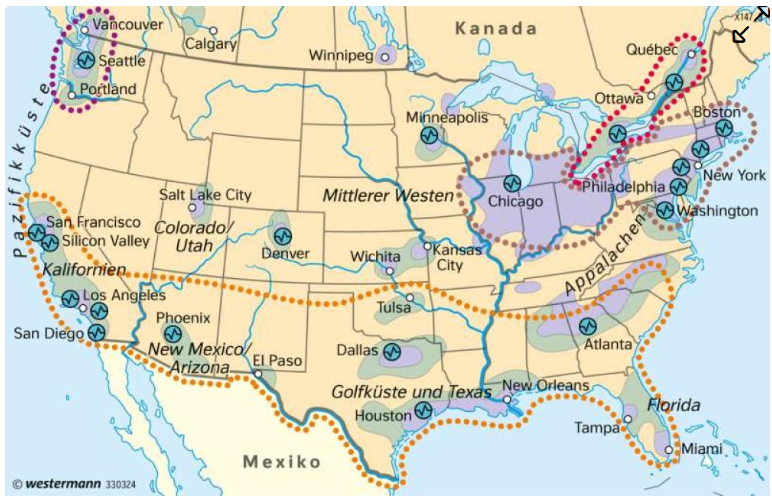

In [85]:
import cv2
from google.colab.patches import cv2_imshow

image_path = '/content/DDM-Project-WS24-25/usa_economic_key_regions.png'
image = cv2.imread(image_path)

cv2_imshow(image)
cv2.waitKey(0)
cv2.destroyAllWindows()

- The Manufacturing Belt around Chicago and Detroit is the largest and oldest industrial region in the U.S., recently impacted by significant structural change.

- The East Coast metropolitan area, from Boston through New York to Washington, is a leading hub for high-tech industries, diverse manufacturing, and major service centers.

- The Portland/Seattle area is known for strong high-tech and aerospace industries, alongside timber processing and paper manufacturing.

- Economic centers in the West include San Francisco and the Silicon Valley (electronics and computer industries) as well as Los Angeles/San Diego (high-tech, heavy and light industries, and services). Together with mining, industrial, high-tech, and service hubs in Phoenix, Dallas, Houston/New Orleans, Atlanta, and Florida, these regions form the Sunbelt, the U.S. economy's growth area.